In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [36]:
class Discriminator(nn.Module):
    def __init__(self, image_dim):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(image_dim, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.discriminator(x)

In [37]:
class Generator(nn.Module):
    def __init__(self, noise_dim, image_dim):
        super().__init__()
        self.generator = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, image_dim),
            nn.Tanh(), # output between -1 and 1 to match normalized inputs
        )
    
    def forward(self, x):
        return self.generator(x)

In [45]:
# ----- Hyperparameters ----- #
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 3e-4 # Andrej Karpathy's recommendation
noise_dim = 64
image_dim = 28 * 28 * 1# 784
batch_size = 32
epochs = 100

In [39]:
discriminator = Discriminator(image_dim).to(device)
generator = Generator(noise_dim, image_dim).to(device)

In [40]:
fixed_noise = torch.randn((batch_size, noise_dim)).to(device) # checking for changes in generated images over epochs

In [41]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [42]:
dataset = datasets.MNIST(root='dataset/', transform=transform, download=True)

In [43]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
generator_optimizer = optim.Adam(generator.parameters(), lr=lr)

loss = nn.BCELoss()

# ---- Tensorboard ---- #
summary_writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
summary_writer_real = SummaryWriter(f"runs/GAN_MNIST/real")
step = 0


In [ ]:
for epoch in range(epochs):
    for batch_indices, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        
        # ----- Train Discriminator ----- #
        
        ### max log(D(x)) + log(1 - D(G(z))) # maxamize (real images are predicted real + fake images are predicted fake)/2
        
        noise = torch.randn((batch_size, noise_dim)).to(device)
        generated_fakes = generator(noise)
        
        discrimnator_of_real = discriminator(real).view(-1)
        lossD_real = loss(discrimnator_of_real, torch.ones_like(discrimnator_of_real)) # torch.ones_like because all outputs should be 1
        
        discriminator_of_fakes = discriminator(generated_fakes).view(-1)
        lossD_fake = loss(discriminator_of_fakes, torch.zeros_like(discriminator_of_fakes)) # torch.zeros_like because all outputs should be 0 since they are fake
        
        lossD = (lossD_real + lossD_fake)/2
        
        discriminator.zero_grad()
        lossD.backward(retain_graph=True)
        discriminator_optimizer.step()
        
        # ----- Train Generator ----- #
        
        ### min log(1-D(G(z))) <-> max log(D(G(z))) # maximize the probability that the discriminator thinks output is real
        
        output = discriminator(generated_fakes).view(-1)
        lossG = loss(output, torch.ones_like(output))
        
        generator.zero_grad()
        lossG.backward()
        generator_optimizer.step()
        
        if batch_indices == 0:
            print(
                f"Epoch [{epoch}/{epochs}] \tLoss D: {lossD:.4f}, Loss G: {lossG:.4f}"
            )
            
            with torch.no_grad():
                fake = generator(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                
                image_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                image_grid_real = torchvision.utils.make_grid(data, normalize=True)
                
                summary_writer_fake.add_image(
                    "MNIST Fake Images", image_grid_fake, global_step=step
                )
                
                summary_writer_real.add_image(
                    "MNIST Real Images", image_grid_real, global_step=step
                )
                
                step += 1

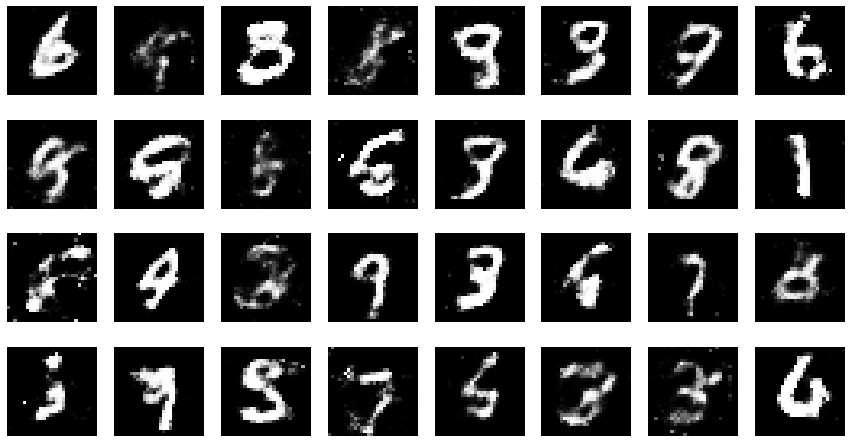

In [47]:
# Testing some outputs

import matplotlib.pyplot as plt

noise = torch.randn((batch_size, noise_dim)).to(device)
generated_fakes = generator(noise)
generated_fakes = generated_fakes.reshape(-1, 1, 28, 28).cpu().detach().numpy()
fig, axes = plt.subplots(4, 8, figsize=(15, 8))
axes = axes.flatten()
for img, ax in zip(generated_fakes, axes):
    ax.imshow(img[0], cmap='gray')
    ax.axis('off')
plt.show()
